# Variational AutoEncoders

Full Name: Zahra Maleki

Student ID: 400110009


# Variational Autoencoder

In this notebook, you will implement a variational autoencoder and a conditional variational autoencoder with slightly different architectures and apply them to the popular MNIST handwritten dataset.

Load several useful packages that are used in this notebook:

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import random
import cv2
import matplotlib as mpl
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [3]:
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Load MNIST Dataset


VAEs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable, we will be working on the MNIST dataset, which has 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy.

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset.

In [7]:
batch_size = 128

mnist_train = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


## Visualize dataset

It is always a good idea to look at examples from the dataset before working with it. Let's visualize the digits in the MNIST dataset. We have defined the function `show_images` to visualize the images.


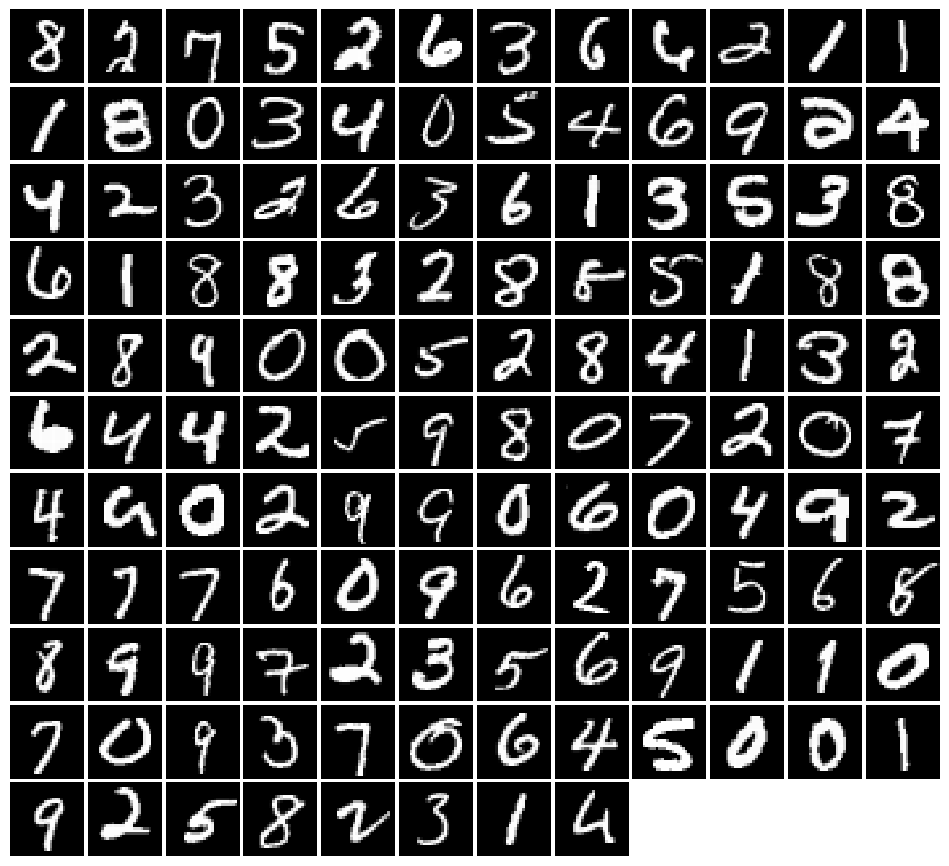

In [5]:
def show_images(images):
    images = torch.reshape(
        images, [images.shape[0], -1]
    )
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([sqrtimg, sqrtimg]))
    return

data_iter = iter(loader_train)
imgs, _ = next(data_iter)
imgs = imgs.view(batch_size, 784)
show_images(imgs)

# Fully Connected VAE

Your first VAE implementation will consist solely of fully connected layers. You'll take the `1 x 28 x 28` shape of our input and flatten the features to create an input dimension size of 784. In this section you'll define the Encoder and Decoder models in the VAE class and implement the reparametrization trick, forward pass, and loss function to train your first VAE.

## FC-VAE Forward

Complete the VAE class by writing the initialization and the forward pass. The forward pass should pass the input image through the encoder to calculate the estimation of mu and logvar, reparametrize to estimate the latent space z, and finally pass z into the decoder to generate an image.



In [8]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200):
      
        super(VAE_MLP, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(

            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        # self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        # self.fc_var = nn.Linear(hidden_dim, latent_dim)
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        self.decoder = nn.Sequential(

            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
        # Decoder layers
        # self.fc3 = nn.Linear(latent_dim, hidden_dim)
        # self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar
        # h1 = F.relu(self.fc1(x))
        # mean = self.fc_mean(h1)
        # log_var = self.fc_var(h1)
        # return mean, log_var

    def reparameterization(self, mean, var):
        
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z
        # std = torch.exp(0.5 * log_var)
        # eps = torch.randn_like(std)
        # z = mean + eps * std
        # return z

    def decode(self, z):
        
        return self.decoder(z)
        # h3 = F.relu(self.fc3(z))
        # reconstruction = torch.sigmoid(self.fc4(h3))
        # return reconstruction

    def forward(self, x):
       
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        reconstruction = self.decode(z)
        return reconstruction, mean, log_var

## Loss Function

Complete the vae_loss function below

In [14]:
# Define VAE loss function

def vae_loss(x, x_hat, mean, log_var, recon_weight=1.0, kl_weight=1.0):
    # TODO: Implement the reconstruction loss
    # TODO: Implement the KL divergence loss
    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum') 

    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    total_loss = reconstruction_loss + kl_divergence

    return total_loss, reconstruction_loss, kl_divergence


## Train a model

Now that we have our VAE defined and loss function ready, lets train our model!

Complete the train_vae_mlp function to train the network.

In [15]:
def train_vae_mlp(model, train_loader, num_epochs=20, learning_rate=1e-3):
    model.to(device) 
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        total_loss = []
        
        for batch_idx, (data, _) in enumerate(train_loader):
           
            data = data.to(device)
            # Flatten the data to 784 dimensions (28x28)
            data = data.view(data.size(0), -1)
            
            x_hat, mean, log_var = model(data)
            
            # Compute loss
            loss, reconstruction_loss, kl_divergence = vae_loss(
                data, x_hat, mean, log_var
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss.append(loss.item())
        
        # Compute average loss for the epoch
        avg_loss = float(sum(total_loss) / len(total_loss))
        print(f"Loss: {avg_loss:.4f}")


In [18]:
# TODO: Train VAE
latent_size = 20  # Size of the latent vector
input_dim = 784  # Input dimension for MNIST (28x28)
hidden_dim = 400  # Hidden layer size
num_epochs = 30  # Number of training epochs
learning_rate = 1e-3  # Learning rate


vae_model = VAE_MLP(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_size)
train_vae_mlp(vae_model, loader_train, num_epochs=num_epochs, learning_rate=learning_rate)

Epoch [1/30]
Loss: 24614.4834
Epoch [2/30]
Loss: 21172.1508
Epoch [3/30]
Loss: 20395.6920
Epoch [4/30]
Loss: 19931.0482
Epoch [5/30]
Loss: 19639.8360
Epoch [6/30]
Loss: 19423.7974
Epoch [7/30]
Loss: 19252.7107
Epoch [8/30]
Loss: 19098.9782
Epoch [9/30]
Loss: 18987.5014
Epoch [10/30]
Loss: 18868.0561
Epoch [11/30]
Loss: 18776.0492
Epoch [12/30]
Loss: 18684.6056
Epoch [13/30]
Loss: 18605.1500
Epoch [14/30]
Loss: 18526.0154
Epoch [15/30]
Loss: 18449.3744
Epoch [16/30]
Loss: 18366.5182
Epoch [17/30]
Loss: 18336.6449
Epoch [18/30]
Loss: 18246.1082
Epoch [19/30]
Loss: 18202.8602
Epoch [20/30]
Loss: 18157.4069
Epoch [21/30]
Loss: 18111.6012
Epoch [22/30]
Loss: 18076.3620
Epoch [23/30]
Loss: 18018.2369
Epoch [24/30]
Loss: 17982.9389
Epoch [25/30]
Loss: 17964.7424
Epoch [26/30]
Loss: 17887.8559
Epoch [27/30]
Loss: 17879.9119
Epoch [28/30]
Loss: 17840.3137
Epoch [29/30]
Loss: 17819.6595
Epoch [30/30]
Loss: 17767.3222


## Visualize results

After training our VAE network, we're able to take advantage of its power to generate new training examples. This process simply involves the decoder: we intialize some random distribution for our latent spaces z, and generate new examples by passing these latent space into the decoder.

Run the cell below to generate new images! You should be able to visually recognize many of the digits, although some may be a bit blurry or badly formed. Our next model will see improvement in these results.

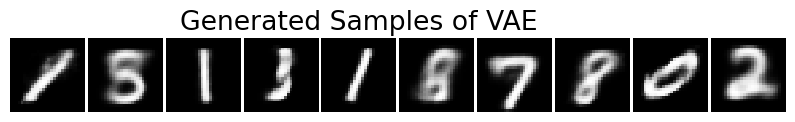

In [19]:
num_samples = 10
latent_size = vae_model.decoder[0].in_features 

z = torch.randn(num_samples, latent_size).to(device=device)

vae_model.eval()
samples = vae_model.decoder(z).data.cpu().numpy()

fig = plt.figure(figsize=(num_samples, 1))
gspec = gridspec.GridSpec(1, num_samples)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    if i == 4:
      plt.title('Generated Samples of VAE')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28,28), cmap='Greys_r')

# Conditional FC-VAE

The second model you'll develop will be very similar to the FC-VAE, but with a slight conditional twist to it. We'll use what we know about the labels of each MNIST image, and *condition* our latent space and image generation on the specific class. Instead of $q_{\phi} (z|x)$ and $p_{\phi}(x|z)$ we have $q_{\phi} (z|x,c)$  and $p_{\phi}(x|z, c)$

This will allow us to do some powerful conditional generation at inference time. We can specifically choose to generate more 1s, 2s, 9s, etc. instead of simply generating new digits randomly.

## Define Network with class input

Your CVAE architecture should be the same as your FC-VAE architecture, except you'll now concatenate a one-hot label vector to both the x input (in our case, the flattened image dimensions) and the z latent space.

If the one-hot vector is called `c`, then `c[label] = 1` and `c = 0` elsewhere.

For the `CVAE_MLP` class use the same FC-VAE architecture implemented in the last network.


In [20]:
class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes, device):
        super(CVAE_MLP, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.input_dim = input_dim + num_classes 
        self.latent_dim = latent_dim + num_classes  
        
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2)
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
       
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std).to(self.device)
        z = mu + std * epsilon
        return z

    def forward(self, x, y):
       
        x = x.view(x.size(0), -1)
        y_one_hot = self.one_hot_encode(y).to(self.device)
        
        x_cond = torch.cat([x, y_one_hot], dim=1)
        hidden = self.encoder(x_cond)
        
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        
        z = self.reparameterize(mu, logvar)
        
        z_cond = torch.cat([z, y_one_hot], dim=1)
        reconstruction = self.decoder(z_cond)
        return reconstruction, mu, logvar

    def one_hot_encode(self, y):
     
        one_hot = torch.zeros(y.size(0), self.num_classes).to(self.device)
        one_hot.scatter_(1, y.unsqueeze(1), 1)
        return one_hot


If you want to build helper functions, you can write the code in the below cell.

# Loss Function

Complete the cvae_loss function below

In [21]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    # TODO: Implement the reconstruction loss
    # TODO: Implement the KL divergence loss
    # TODO: Implement the cross-entropy loss for class prediction
    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses

    data = data.view(data.size(0), -1)
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    if class_logits is not None and labels is not None:
        classification_loss = F.cross_entropy(class_logits, labels, reduction='sum')
    else:
        classification_loss = 0.0 

    total_loss = reconstruction_loss + kl_divergence + classification_loss

    return total_loss, reconstruction_loss, kl_divergence, classification_loss


## Train model

Using the same training script, let's now train our CVAE!



In [23]:
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.to(device)  
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):

        print(f"\n{'='*45}\nEpoch [{epoch + 1}/{num_epochs}]")
        total_loss, total_recon_loss, total_kl_loss, total_class_loss = [], [], [], []

        for batch_idx, (data, labels) in enumerate(train_loader):
            
            data, labels = data.to(device), labels.to(device)
        
            labels_one_hot = model.one_hot_encode(labels)
            recon, mu, logvar = model(data, labels)
            
            total_batch_loss, recon_loss, kl_loss, class_loss = cvae_loss(
                recon, data, mu, logvar, class_logits=None, labels=None
            )
            
            optimizer.zero_grad()
            total_batch_loss.backward()
            optimizer.step()

            total_loss.append(total_batch_loss.item())
            total_recon_loss.append(recon_loss.item())
            total_kl_loss.append(kl_loss.item())
            total_class_loss.append(class_loss if isinstance(class_loss, float) else class_loss.item())

        avg_loss = float(sum(total_loss) / len(total_loss))
        avg_recon_loss = float(sum(total_recon_loss) / len(total_recon_loss))
        avg_kl_loss = float(sum(total_kl_loss) / len(total_kl_loss))
        avg_class_loss = float(sum(total_class_loss) / len(total_class_loss))

        print(f"Loss: {avg_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}, Class Loss: {avg_class_loss:.4f}")


In [24]:
# TODO: Train CVAE

latent_size = 20  
input_dim = 784  
hidden_dim = 400  
num_classes = 10 
num_epochs = 30  
learning_rate = 1e-3  

cvae_model = CVAE_MLP(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_size, num_classes=num_classes, device=device)
train_cvae_mlp(cvae_model, loader_train, num_epochs=num_epochs, learning_rate=learning_rate)



Epoch [1/30]
Loss: 20418.0363, Recon Loss: 19148.3531, KL Loss: 1269.6832, Class Loss: 0.0000

Epoch [2/30]
Loss: 15030.3425, Recon Loss: 12898.3863, KL Loss: 2131.9563, Class Loss: 0.0000

Epoch [3/30]
Loss: 14110.0768, Recon Loss: 11831.9244, KL Loss: 2278.1524, Class Loss: 0.0000

Epoch [4/30]
Loss: 13670.6709, Recon Loss: 11340.1763, KL Loss: 2330.4946, Class Loss: 0.0000

Epoch [5/30]
Loss: 13391.3010, Recon Loss: 11042.1841, KL Loss: 2349.1169, Class Loss: 0.0000

Epoch [6/30]
Loss: 13194.1489, Recon Loss: 10835.4956, KL Loss: 2358.6533, Class Loss: 0.0000

Epoch [7/30]
Loss: 13041.0982, Recon Loss: 10677.7179, KL Loss: 2363.3804, Class Loss: 0.0000

Epoch [8/30]
Loss: 12923.5689, Recon Loss: 10554.0430, KL Loss: 2369.5260, Class Loss: 0.0000

Epoch [9/30]
Loss: 12822.2332, Recon Loss: 10446.5398, KL Loss: 2375.6934, Class Loss: 0.0000

Epoch [10/30]
Loss: 12733.3445, Recon Loss: 10352.9982, KL Loss: 2380.3463, Class Loss: 0.0000

Epoch [11/30]
Loss: 12667.5294, Recon Loss: 1027

## Visualize Results

You've trained your CVAE, now let's conditionally generate some new data! This time, we can specify the class we want to generate by adding our one hot matrix of class labels. We use `torch.eye` to create an identity matrix, which effectively gives us one label for each digit. When you run the cell below, you should get one example per digit. Each digit should be reasonably distinguishable (it is ok to run this cell a few times to save your best results).



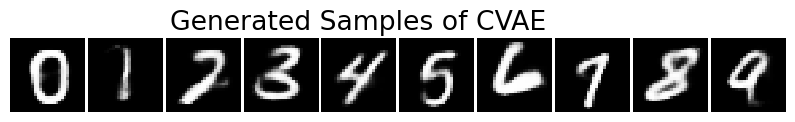

In [27]:
num_samples = 10
z = torch.randn(num_samples, latent_size)

c = torch.eye(num_samples, 10)

z = torch.cat((z,c), dim=-1).to(device='cuda')
cvae_model.eval()
samples = cvae_model.decoder(z).data.cpu().numpy()

fig = plt.figure(figsize=(num_samples, 1))
gspec = gridspec.GridSpec(1, num_samples)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    if i == 4:
      plt.title('Generated Samples of CVAE')
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')